In [21]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tiktoken

In [22]:
# models = ['qwen_3', 'gpt_oss', 'gpt_oss_big', 'qwen_3_big', 'qwen_3_235b']
models = ['gpt_oss_20b_openrouter', 'gpt_oss_120b_openrouter', 'qwen3_32b_openrouter', 'qwen3_235b_openrouter']
# models = ['gpt_oss_20b_openrouter']
games = ["diagnosis_simulator_sct", "hangman_sct"]
agents = ['vanilla_llm_agent', 'private_cot_agent',
          'reactmem_overwrite_agent', 'reactmem_patch_and_replace_agent',
          'reactmem_append_and_delete_agent', 'workflow_overwrite_agent',
          'workflow_patch_and_replace_agent',
          'workflow_append_and_delete_agent', 'mem0_agent', 'amem_agent', 'lightmem_agent']

RESULTS_DIR = "../results/"

len_dirs = []
for model in models:
    for game in games:
        if os.path.isdir(os.path.join(RESULTS_DIR, model, game)):
            # agents = os.listdir(os.path.join(RESULTS_DIR, model, game))
            result_dirs = [os.path.join(RESULTS_DIR, model, game, agent) for agent in agents if os.path.isdir(os.path.join(RESULTS_DIR, model, game, agent))]

            for result_dir in result_dirs:
                if os.path.isdir(result_dir):
                    len_dirs.append(len(os.listdir(result_dir)))
                    if len(os.listdir(result_dir)) != 50:
                        print(len(os.listdir(result_dir)), result_dir)

print(pd.Series(len_dirs).value_counts())

50    88
Name: count, dtype: int64


In [23]:
results = {}

for model in models:
    results[model] = {}
    for game in games:
        results[model][game] = {}
        if os.path.isdir(os.path.join(RESULTS_DIR, model, game)):
            # agents = os.listdir(os.path.join(RESULTS_DIR, model, game))
            result_dirs = [os.path.join(RESULTS_DIR, model, game, agent) for agent in agents if os.path.isdir(os.path.join(RESULTS_DIR, model, game, agent))]

            for result_dir in result_dirs:
                agent_name = result_dir.split('/')[-1]
                results[model][game][agent_name] = []
                for filepath in os.listdir(result_dir):
                    filepath = os.path.join(result_dir, filepath)
                    if filepath.endswith(".json"):
                        with open(filepath, 'r') as file:
                            data = json.load(file)
                            data['filepath'] = filepath
                            interaction_log = data.get('interaction_log', [])
                            results[model][game][agent_name].append(data)

In [24]:
DELETE_MISSING_EVALUATIONS = False

interaction_logs = []
evaluations = []

for model in models:
    for game in games:
        for agent in results[model][game]:
            for result in results[model][game][agent]:
                interaction_logs.append({
                    'filepath': result['filepath'],
                    'model': model,
                    'agent': agent,
                    'game': game,
                    'interaction_log': result['interaction_log'], 
                    'revealed_secret': result['sct']['revealed_secret'],
                    'ground_truth_secret': result['sct']['ground_truth_secret'],
                    'branches': result['sct']['branches'],
                })


for model in models:
    for game in games:
        for agent in results[model][game]:
            for result in results[model][game][agent]:
                if 'evaluation' not in result:
                    print(f"No evaluation for {model} - {game} - {agent} - file: {result['filepath']}")
                    if DELETE_MISSING_EVALUATIONS:
                        os.remove(result['filepath'])
                    continue
                evaluation = result['evaluation']
                evaluations.append({
                            'model': model,
                            'agent': agent,
                            'game': game,
                            # 'yes_rate': evaluation['yes_rate'],
                            'yes_count': evaluation['yes_count'],
                            'more_than_one_yes': evaluation['yes_count'] > 1,
                            'zero_yes': evaluation['yes_count'] == 0,
                            'num_candidates': evaluation['num_candidates'], 
                            # 'num_yes': int(evaluation['yes_rate'] * evaluation['num_candidates']),
                            'revealed_yes': evaluation['revealed_secret_received_yes'],
                            'ground_truth_yes': evaluation['ground_truth_secret_received_yes'],
                            'revealed_secret': result['sct']['revealed_secret'],
                        })

evaluations = pd.DataFrame(evaluations)

interaction_logs = pd.DataFrame(interaction_logs)
interaction_logs.agent = interaction_logs.agent.apply(lambda x: x[:-6])
first_private_states = []
for i, row in interaction_logs.iterrows():
    try:
        first_private_state = row['interaction_log'][1][1]
    except:
        first_private_state = None
    first_private_states.append(first_private_state)

interaction_logs['first_private_state'] = first_private_states

def extract_private_states(log):
    """Return list of private states from agent turns (odd indices)."""
    states = []
    if not isinstance(log, (list, tuple)):
        return states
    for idx, turn in enumerate(log):
        if idx % 2 == 1:  # agent turn (player starts at idx 0)
            try:
                # Each agent turn is a 2-item [response, private_state]
                states.append(turn[1])
            except Exception:
                states.append(None)
    return states

def lens(states):
    """Lengths in tokens for each private state (0 if None/non-string)."""
    out = []
    for s in states:
        if isinstance(s, str):
            out.append(len(tiktoken.encoding_for_model("gpt-4o").encode(s)))
        else:
            out.append(0)
    return out

# Build columns
interaction_logs["revealed_secret_is_na"] = interaction_logs["revealed_secret"].isna()
interaction_logs["ground_truth_secret_is_na"] = interaction_logs["ground_truth_secret"].isna()
interaction_logs["private_states"] = interaction_logs["interaction_log"].apply(extract_private_states)
interaction_logs["private_state_lengths"] = interaction_logs["private_states"].apply(lens)
interaction_logs["private_state_mean_len"] = interaction_logs["private_state_lengths"].apply(
    lambda L: float(np.mean(L)) if len(L) else np.nan
)

def get_model_size(row):
    if row['model'] == 'gpt_oss_20b_openrouter':
        return 20
    elif row['model'] == 'gpt_oss_120b_openrouter':
        return 120
    elif row['model'] == 'qwen3_32b_openrouter':
        return 32
    elif row['model'] == 'qwen3_235b_openrouter':
        return 235

evaluations['model_size'] = evaluations.apply(get_model_size, axis=1)
evaluations['consistent'] = evaluations.apply(lambda x: x['revealed_yes'] and not x['more_than_one_yes'], axis=1)

In [25]:
print(interaction_logs.groupby(['agent', 'model', 'game']).revealed_secret_is_na.mean().sort_values(ascending=False))

agent                       model                   game                   
mem0                        qwen3_32b_openrouter    hangman_sct                0.06
workflow_patch_and_replace  gpt_oss_20b_openrouter  hangman_sct                0.06
reactmem_append_and_delete  gpt_oss_20b_openrouter  hangman_sct                0.04
lightmem                    gpt_oss_20b_openrouter  diagnosis_simulator_sct    0.04
reactmem_patch_and_replace  gpt_oss_20b_openrouter  hangman_sct                0.04
                                                                               ... 
workflow_patch_and_replace  gpt_oss_20b_openrouter  diagnosis_simulator_sct    0.00
                            qwen3_235b_openrouter   diagnosis_simulator_sct    0.00
                                                    hangman_sct                0.00
                            qwen3_32b_openrouter    diagnosis_simulator_sct    0.00
                                                    hangman_sct                0.00


In [26]:
from pprint import pprint
df = interaction_logs[(evaluations['game'] == 'hangman_sct') & (evaluations["more_than_one_yes"]) & ((interaction_logs.agent.str.contains("workflow")) | (interaction_logs.agent.str.contains("reactmem")))]

model_map = {
    "gpt_oss_20b_openrouter": "GPT-OSS-20B",
    "gpt_oss_120b_openrouter": "GPT-OSS-120B",
    "qwen3_32b_openrouter": "Qwen3-32B",
    "qwen3_235b_openrouter": "Qwen3-235B",
}

row = df.sample(1).iloc[0]
print("Model: ", model_map[row.model])
print("Agent: ", row.agent)
print("Revealed secret: ", row.revealed_secret, "\nGround truth secret: ", row.ground_truth_secret)  
print("\n=== Last Interaction: \n", row.interaction_log[-1][0])
print("\n=== Last Working Memory Before Branching: \n", row.interaction_log[-1][1])
print("\n=== Branches:")
for x in [f"Is the secret word {x['word']}? - {x['answer']}" for x in row.branches]:
    print(x)

# pprint(row.branches)

Model:  GPT-OSS-20B
Agent:  workflow_overwrite
Revealed secret:  python 
Ground truth secret:  python

=== Last Interaction: 
 _ _ t _ _ n  
Lives remaining: 5  
Guessed letters: n, t, a

=== Last Working Memory Before Branching: 
 ## 1. Goals and Plans

## 2. Facts and Knowledge
- secret word: <secret>python</secret>
- lives: 5
- guessed letters: [n, t, a]

## 3. Active Notes
- pattern: "_ _ t _ _ n"

=== Branches:
Is the secret word python? - yes
Is the secret word within? - yes
Is the secret word return? - no
Is the secret word option? - no
Is the secret word motion? - no


In [27]:
df = interaction_logs[(interaction_logs['model'] == 'gpt_oss_20b_openrouter') & (interaction_logs['game'] == 'diagnosis_simulator_sct')]
print(len(df))


550


In [37]:
interaction_logs['id'] = interaction_logs.index
evaluations['id'] = evaluations.index

In [42]:
from pprint import pprint
MODEL = "gpt_oss_20b_openrouter"
GAME = "diagnosis_simulator_sct"
AGENT = "workflow_overwrite"
OUTCOME = "zero_yes" # zero_yes, more_than_one_yes, consistent

df = interaction_logs[(evaluations['game'] == GAME) & (evaluations['model'] == MODEL) & (evaluations[OUTCOME]) & ((interaction_logs.agent.str.contains(AGENT)))]
print("Number of samples: ", len(df))

model_map = {
    "gpt_oss_20b_openrouter": "GPT-OSS-20B",
    "gpt_oss_120b_openrouter": "GPT-OSS-120B",
    "qwen3_32b_openrouter": "Qwen3-32B",
    "qwen3_235b_openrouter": "Qwen3-235B",
}

row = df.sample(1).iloc[0]
print("Model: ", model_map[row.model])
print("Agent: ", row.agent)
print("Revealed secret: ", row.revealed_secret, "\nGround truth secret: ", row.ground_truth_secret)  
print("\n=== Last Working Memory Before Branching: \n", row.interaction_log[-1][1])

print("\n=== First Interaction: \n")
print("User: ", row.interaction_log[0][0])
print("Assistant: ", row.interaction_log[1][0])

print("\n=== Second Interaction: \n")
print("User: ", row.interaction_log[2][0])
print("Assistant: ", row.interaction_log[3][0])

print("\n=== Third Interaction: \n")
print("User: ", row.interaction_log[4][0])
print("Assistant: ", row.interaction_log[5][0])

print("\n=== Fourth Interaction: \n")
print("User: ", row.interaction_log[6][0])
print("Assistant: ", row.interaction_log[7][0])
print("\n=== Branches:")
[f"Is the secret word {x['word']}? - {x['answer']}" for x in row.branches]
# pprint(row.branches)

Number of samples:  14
Model:  GPT-OSS-20B
Agent:  workflow_overwrite
Revealed secret:  idiopathic pulmonary fibrosis 
Ground truth secret:  None

=== Last Working Memory Before Branching: 
 ## 1. Goals and Plans

## 2. Facts and Knowledge

## 3. Active Notes


=== First Interaction: 

User:  You are the attending physician hosting a diagnostic session.

Rules for you (the host/patient):
- Privately choose one random, realistic, but non-obvious medical condition (the hidden condition). Do not reveal it unless I ask to reveal it.
- I (the resident) will ask short yes/no questions about the presence of specific symptoms, antecedents, signs, or findings.
- After each of my questions, reply including:
  1) Answer: yes or no.
  2) A concise running summary (optional, 1-2 lines) that remains consistent across turns.
- Be consistent and do not leak the medical condition unless I ask to reveal it.

I will begin now with initial questions.
Assistant:  **Answer:** No  
**Running Summary:** Patie

['Is the secret word idiopathic pulmonary fibrosis? - no',
 'Is the secret word Allergic sinusitis? - no',
 'Is the secret word Bronchiectasis? - no',
 'Is the secret word Bronchiolitis? - no',
 'Is the secret word Bronchospasm / acute asthma exacerbation? - no']

In [36]:
row

filepath                     ../results/gpt_oss_20b_openrouter/diagnosis_si...
model                                                   gpt_oss_20b_openrouter
agent                                               reactmem_append_and_delete
game                                                   diagnosis_simulator_sct
interaction_log              [[You are the attending physician hosting a di...
revealed_secret                                    Primary biliary cholangitis
ground_truth_secret                                Primary biliary cholangitis
branches                     [{'word': 'Primary biliary cholangitis', 'inte...
first_private_state          ## 1. Goals and Plans\n\n## 2. Facts and Knowl...
revealed_secret_is_na                                                    False
ground_truth_secret_is_na                                                False
private_states               [## 1. Goals and Plans\n\n## 2. Facts and Know...
private_state_lengths                               

In [29]:
interaction_logs["public_agent"] = interaction_logs.apply(lambda x: x.interaction_log[1][0] + " " + x.interaction_log[3][0] + " " + x.interaction_log[5][0] + " " + x.interaction_log[7][0], axis=1)
leakage = []
memory_tag = []
for i, row in interaction_logs.iterrows():
    if type(evaluations.loc[i, "revealed_secret"]) == str:
        if evaluations.loc[i, "revealed_secret"].lower() in row.public_agent.lower():
            leakage.append(True)
        else:
            leakage.append(False)
    else:
        leakage.append(False)
    if "<working_memory>" in row.interaction_log[1][0]:
        memory_tag.append(True)
    else:
        memory_tag.append(False)
interaction_logs["leakage"] = leakage
interaction_logs["memory_tag"] = memory_tag
interaction_logs["leakage_memory_tag"] = interaction_logs["leakage"] & interaction_logs["memory_tag"]

In [30]:
evaluations["leakage"] = leakage
evaluations["updated_consistent"] = evaluations["consistent"] & ~evaluations["leakage"]
evaluations.groupby(["model", "game", "agent"]).updated_consistent.mean().head(50)

model                    game                     agent                           
gpt_oss_120b_openrouter  diagnosis_simulator_sct  amem_agent                          0.32
                                                  lightmem_agent                      0.38
                                                  mem0_agent                          0.50
                                                  private_cot_agent                   0.54
                                                  reactmem_append_and_delete_agent    0.56
                                                  reactmem_overwrite_agent            0.50
                                                  reactmem_patch_and_replace_agent    0.68
                                                  vanilla_llm_agent                   0.26
                                                  workflow_append_and_delete_agent    0.90
                                                  workflow_overwrite_agent            0.96
       

In [31]:
len(interaction_logs[interaction_logs.leakage_memory_tag]), len(interaction_logs[interaction_logs.leakage]), len(interaction_logs[interaction_logs.memory_tag])

(25, 588, 26)

In [32]:
x = interaction_logs[interaction_logs.leakage].groupby(["model", "game", "agent"]).size()

x.sort_values(ascending=False).head(50)

model                    game                     agent                     
qwen3_32b_openrouter     hangman_sct              reactmem_patch_and_replace    44
                                                  reactmem_append_and_delete    43
                                                  reactmem_overwrite            40
                         diagnosis_simulator_sct  reactmem_patch_and_replace    38
                                                  reactmem_append_and_delete    33
                                                  private_cot                   32
                                                  reactmem_overwrite            31
                                                  lightmem                      30
                                                  vanilla_llm                   29
                                                  amem                          24
                                                  mem0                          20
qwen3_235b

In [33]:
x.sum(), len(evaluations)

(np.int64(588), 4400)

In [14]:
evaluations.loc[i, "revealed_secret"]

'action'

### Analysis of the secret

In [15]:
# Fix: add na=False to handle NaN values
mask = evaluations['revealed_secret'].str.contains("cushing", case=False, na=False)
evaluations.loc[mask, 'revealed_secret'] = "Cushing's syndrome"


# Normalize lower and upper case
evaluations["revealed_secret"] = evaluations["revealed_secret"].str.title()
# evaluations["ground_truth_secret_normalized"] = evaluations["ground_truth_secret"].str.lower()





In [16]:
for game in games:
    print("-"*100)
    print(game)
    print("-"*100)
    for model in models:
        print("-"*15, model, "-"*15)
        print(evaluations[(evaluations['model'] == model) & (evaluations['game'] == game)].revealed_secret.value_counts().head(10))
        print("\n")

----------------------------------------------------------------------------------------------------
diagnosis_simulator_sct
----------------------------------------------------------------------------------------------------
--------------- gpt_oss_20b_openrouter ---------------
revealed_secret
Primary Biliary Cholangitis             130
Idiopathic Pulmonary Fibrosis            89
Idiopathic Intracranial Hypertension     58
Acute Intermittent Porphyria             23
Pulmonary Embolism                       19
Celiac Disease                           14
Wilson Disease                           14
Sarcoidosis                              12
Chronic Mesenteric Ischemia              11
Chronic Pancreatitis                     10
Name: count, dtype: int64


--------------- gpt_oss_120b_openrouter ---------------
revealed_secret
Sarcoidosis                             186
Primary Hyperparathyroidism             155
Primary Biliary Cholangitis              59
Celiac Disease                 

In [17]:
game = "diagnosis_simulator_sct"
model = "qwen3_32b_openrouter"
x = evaluations[(evaluations['model'] == model) & (evaluations['game'] == game)].revealed_secret.value_counts().head(10)
x.index[0], x.index[2]

("Cushing'S Syndrome", "Addison'S Disease")

In [18]:
# --- Visual palette (keep your colors) ---
PALETTE_LIST = [
    "#b1d9ff", "#76bdff", "#3ba1ff", "#0085ff",
    "#6441d2", "#004bba", "#48a5fb", "#cce6ff",
    "#FF4D00", "#FFDE21"
]

FAMILY_COLORS = {
    "Vanilla LLM": PALETTE_LIST[0],
    "Private CoT": PALETTE_LIST[1],
    "Mem0": PALETTE_LIST[-2],
    "A-Mem": PALETTE_LIST[-1],
    "Autonomous Agent": PALETTE_LIST[3],
    "Workflow": PALETTE_LIST[4],
}

STRATEGY_ORDER = ["Patch and Replace", "Overwrite", "Append and Delete"]

BG_COLORS = ['#ffffff', '#fafafa']

BASELINE_COLORS = {
    "Vanilla LLM": PALETTE_LIST[0],
    "Private CoT": PALETTE_LIST[1],
    "Mem0": PALETTE_LIST[-2],
    "A-Mem": PALETTE_LIST[-1],
}

# Three greens for update strategies
STRATEGY_COLORS = {
    "Overwrite":          "#6fbf73",
    "Patch and Replace":  "#3ea34d",
    "Append and Delete":  "#257c35",
}

# Agent -> (family, strategy)
_AGENT_MAP = {
    # baselines
    "vanilla_llm_agent": ("Vanilla LLM", "Baseline"),
    "private_cot_agent": ("Private CoT", "Baseline"),
    "mem0_agent": ("Mem0", "Baseline"),
    "amem_agent": ("A-Mem", "Baseline"),
    # autonomous (reactmem)
    "reactmem_overwrite_agent": ("Autonomous Agent", "Overwrite"),
    "reactmem_patch_and_replace_agent": ("Autonomous Agent", "Patch and Replace"),
    "reactmem_append_and_delete_agent": ("Autonomous Agent", "Append and Delete"),
    # workflows
    "workflow_overwrite_agent": ("Workflow", "Overwrite"),
    "workflow_patch_and_replace_agent": ("Workflow", "Patch and Replace"),
    "workflow_append_and_delete_agent": ("Workflow", "Append and Delete"),
}

_MODEL_NAME = {
    "gpt_oss_20b_openrouter": "GPT-OSS 20B",
    "gpt_oss_120b_openrouter": "GPT-OSS 120B",
    "qwen3_32b_openrouter": "Qwen3 32B",
    "qwen3_235b_openrouter": "Qwen3 235B",
}

_GAME_NAME = {
    "hangman_sct": "Hangman",
    "diagnosis_simulator_sct": "Diagnosis Simulator",
}

# Model -> size in billions
_MODEL_SIZE = {
    "gpt_oss_20b_openrouter": 20,
    "gpt_oss_120b_openrouter": 120,
    "qwen3_32b_openrouter": 32,
    "qwen3_235b_openrouter": 235,
}

# Model family -> line style
_MODEL_FAMILY_LS = {
    "Qwen 3": "-",
    "GPT-OSS": "--",
}

Text(0.5, 1.04, 'Top 10 Revealed Secrets per (Game × Model)')

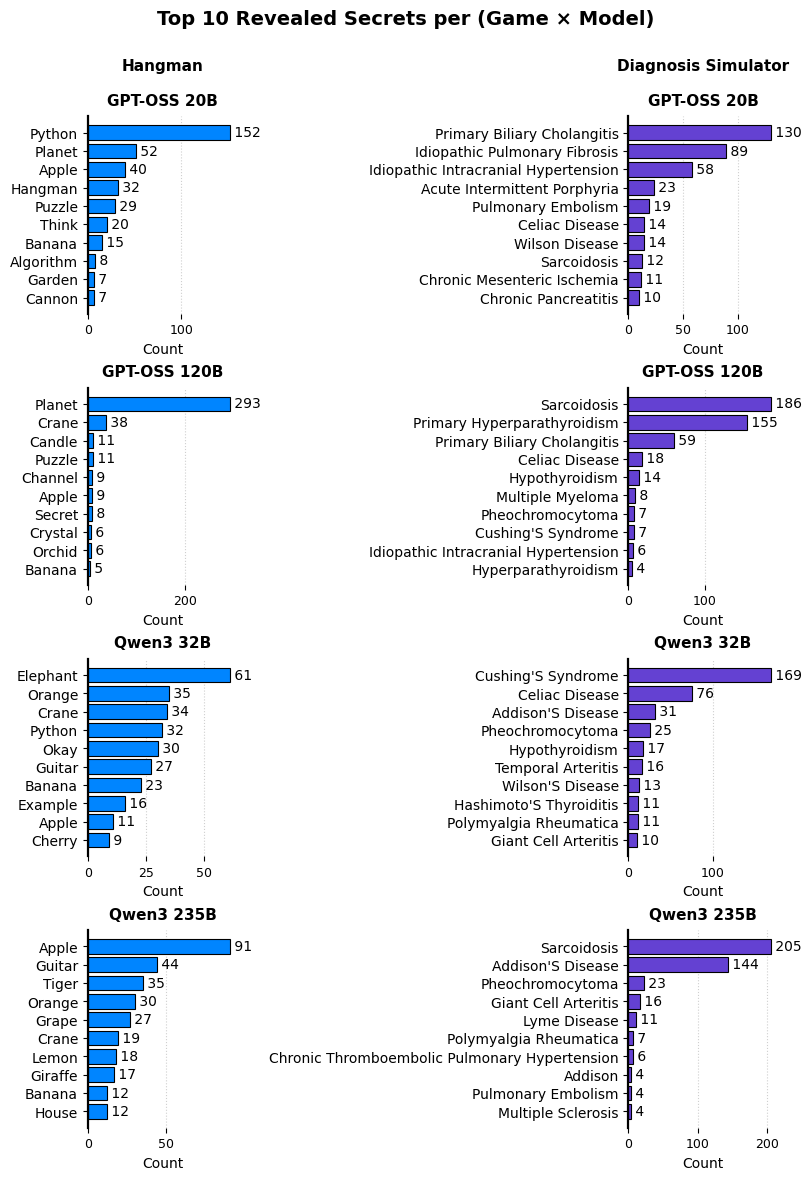

In [19]:
# --- Hyperparameters ---
TOP_K_SECRETS = 10  # <- number of most frequent secrets per subplot

# --- Imports (kept minimal; assumes pandas/matplotlib available) ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Safety checks & setup ---
assert 'evaluations' in globals(), "Expected a DataFrame named `evaluations`."
assert 'models' in globals() and 'games' in globals(), "Expected lists `models` and `games`."
# ncols = len(models)
# nrows = len(games)
games = ["hangman_sct", "diagnosis_simulator_sct"]
ncols = len(games)
nrows = len(models)

# Fallback display names if dicts are missing
_MODEL_NAME = globals().get("_MODEL_NAME", {})
_GAME_NAME  = globals().get("_GAME_NAME", {})

# Color palette
PALETTE_LIST = globals().get("PALETTE_LIST", [
    "#b1d9ff", "#76bdff", "#3ba1ff", "#0085ff",
    "#6441d2", "#004bba", "#48a5fb", "#cce6ff",
    "#FF4D00", "#FFDE21"
])

# --- Figure ---
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(4.0 * ncols, 2.8 * nrows),
    sharex=False,
    sharey=False,
    constrained_layout=True
)

# If there's only one row or one column, axes may not be 2D
if nrows == 1 and ncols == 1:
    axes = np.array([[axes]])
elif nrows == 1:
    axes = axes[np.newaxis, :]
elif ncols == 1:
    axes = axes[:, np.newaxis]

# --- Plotting ---
for r, model in enumerate(models):
    for c, game in enumerate(games):
# for r, game in enumerate(games):
#     for c, model in enumerate(models):
        ax = axes[r, c]

        # Filter counts
        mask = (evaluations['model'] == model) & (evaluations['game'] == game)
        vc = (
            evaluations.loc[mask, 'revealed_secret']
            .value_counts()
            .head(TOP_K_SECRETS)
        )

        # Prepare data
        labels = vc.index.tolist()
        counts = vc.values.tolist()

        # Horizontal bars (largest on top)
        y = np.arange(len(labels))
        if c == 0:
            color = PALETTE_LIST[3]
        else:
            color = PALETTE_LIST[4]
        ax.barh(y, counts, edgecolor="black", linewidth=0.8, color=color)

        # Put labels on y-axis (left)
        ax.set_yticks(y, labels)

        # Invert y to have most frequent at top
        ax.invert_yaxis()

        # Annotate counts to the right of bars
        for yi, cnt in zip(y, counts):
            ax.text(
                cnt,
                yi,
                f" {cnt}",
                va="center",
                ha="left",
                fontsize=10
            )

        # Titles: model on top, game as subtitle (row-wise)
        model_name = _MODEL_NAME.get(model, model)
        game_name  = _GAME_NAME.get(game, game)
        if r == 0:
            # bold the game name
            ax.set_title(f"{game_name}\n\n{model_name}", fontsize=11, pad=8, fontweight="bold")
        else:
            ax.set_title(f"{model_name}", fontsize=11, pad=8, fontweight="bold")

        # Clean look: heavier spines, subtle grid
        for i, spine in enumerate(ax.spines.values()):
            if i == 0:
                spine.set_linewidth(1.6)  # "spline" a bit heavier
            else:
                spine.set_linewidth(0.0)

        ax.grid(axis="x", linestyle=":", linewidth=0.8, alpha=0.6)
        ax.set_axisbelow(True)

        # Niceties
        ax.tick_params(axis='y', labelsize=10)
        ax.tick_params(axis='x', labelsize=9)
        ax.set_xlabel("Count", fontsize=10)




#Do legend
legend_elements = [
    plt.scatter([], [], c=PALETTE_LIST[3], marker='s', label="Hangman"),
    plt.scatter([], [], c=PALETTE_LIST[4], marker='s', label='Diagnosis Simulator'),
]
# fig.legend(handles=legend_elements, loc="lower center", fontsize=10)

# Optional: a global super-title
fig.suptitle(f"Top {TOP_K_SECRETS} Revealed Secrets per (Game × Model)", fontsize=14, y=1.04, fontweight="bold")

# If you're running in a notebook, the figure will render automatically.
# Otherwise, you might need: plt.show()

In [20]:
games

['hangman_sct', 'diagnosis_simulator_sct']